In [1]:
import pandas as pd; pd.set_option('display.max_rows', 1000); pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True) # sns.set(style='darkgrid')

import geopandas as gpd # http://geopandas.org/gallery/plotting_basemap_background.html#sphx-glr-gallery-plotting-basemap-background-py
import contextily as ctx

import shapely.wkt # https://stackoverflow.com/questions/51855917/shapely-polygon-from-string
from shapely.geometry import Point, LineString, MultiLineString, Polygon
from shapely.ops import cascaded_union

In [2]:
df = pd.read_csv('NYPD_Arrests_Data__Historic_.csv')

In [3]:
df.shape

(4798339, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4798339 entries, 0 to 4798338
Data columns (total 18 columns):
ARREST_KEY           int64
ARREST_DATE          object
PD_CD                float64
PD_DESC              object
KY_CD                float64
OFNS_DESC            object
LAW_CODE             object
LAW_CAT_CD           object
ARREST_BORO          object
ARREST_PRECINCT      int64
JURISDICTION_CODE    float64
AGE_GROUP            object
PERP_SEX             object
PERP_RACE            object
X_COORD_CD           float64
Y_COORD_CD           float64
Latitude             float64
Longitude            float64
dtypes: float64(7), int64(2), object(9)
memory usage: 659.0+ MB


In [5]:
def Data_Stat(df, n_row_view = 3):
    types = pd.Series({c:str(df[c].dtype) for c in df.columns}) # variable type
    total = df.isnull().sum() # the number of null values
    percent = 100 * total / df.isnull().count() # the percentage of null values
    n_unique = df.nunique() # the number of unique values
    
    tt = np.transpose(pd.concat([types, total, percent, n_unique], axis=1, keys=['Types', '# of nulls', '% of nulls', '# of uniques']))
    return pd.concat([df.head(n_row_view), tt], axis = 0)

Data_Stat(df)
# df.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,173130602,12/31/2017,566,"MARIJUANA, POSSESSION",678,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,0,25-44,M,BLACK,1.06306e+06,207463,40.7358,-73.7156
1,173114463,12/31/2017,478,"THEFT OF SERVICES, UNCLASSIFIED",343,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,Q,114,0,25-44,M,ASIAN / PACIFIC ISLANDER,1.00911e+06,219613,40.7694,-73.9102
2,173113513,12/31/2017,849,"NY STATE LAWS,UNCLASSIFIED VIOLATION",677,OTHER STATE LAWS,LOC000000V,V,K,73,1,18-24,M,BLACK,1.01072e+06,186857,40.6795,-73.9046
Types,int64,object,float64,object,float64,object,object,object,object,int64,float64,object,object,object,float64,float64,float64,float64
# of nulls,0,0,220,8870,8870,8870,196,16103,8,0,10,17,0,0,1,1,1,1
% of nulls,0,0,0.00458492,0.184856,0.184856,0.184856,0.00408475,0.335595,0.000166724,0,0.000208405,0.000354289,0,0,2.08405e-05,2.08405e-05,2.08405e-05,2.08405e-05
# of uniques,4798339,4748,325,351,75,75,2349,4,5,78,27,91,2,8,63564,66362,99618,99621


In [6]:
df['ARREST_DATE'] = pd.to_datetime(df['ARREST_DATE'], format='%m/%d/%Y')
df['year'] = df['ARREST_DATE'].dt.year
df['month'] = df['ARREST_DATE'].dt.month
df['day'] = df['ARREST_DATE'].dt.day
df['dayofweek'] = df['ARREST_DATE'].dt.dayofweek
df['hour'] = df['ARREST_DATE'].dt.hour

df['location'] = df[['Longitude','Latitude']].apply(lambda x: Point(x[0],x[1]), axis=1)

df['count'] = 1

df.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,month,day,dayofweek,hour,location,count
0,173130602,2017-12-31,566.0,"MARIJUANA, POSSESSION",678.0,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,0.0,25-44,M,BLACK,1063056.0,207463.0,40.735772,-73.715638,2017,12,31,6,0,POINT (-73.715638255 40.73577180300003),1
1,173114463,2017-12-31,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,Q,114,0.0,25-44,M,ASIAN / PACIFIC ISLANDER,1009113.0,219613.0,40.769437,-73.910241,2017,12,31,6,0,POINT (-73.91024071099997 40.76943659700004),1
2,173113513,2017-12-31,849.0,"NY STATE LAWS,UNCLASSIFIED VIOLATION",677.0,OTHER STATE LAWS,LOC000000V,V,K,73,1.0,18-24,M,BLACK,1010719.0,186857.0,40.679525,-73.904572,2017,12,31,6,0,POINT (-73.90457153799997 40.67952470300003),1
3,173113423,2017-12-31,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,25-44,M,WHITE,987831.0,217446.0,40.763523,-73.987074,2017,12,31,6,0,POINT (-73.98707442499993 40.76352297700004),1
4,173113421,2017-12-31,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,45-64,M,BLACK,987073.0,216078.0,40.759768,-73.989811,2017,12,31,6,0,POINT (-73.98981129799995 40.75976844200004),1


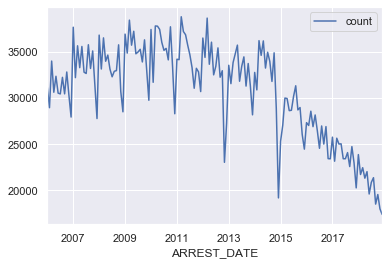

In [7]:
df.set_index('ARREST_DATE').resample('M').count().plot(y='count')

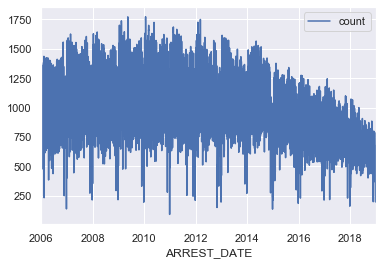

In [8]:
df.set_index('ARREST_DATE').resample('D').count().plot(y='count')

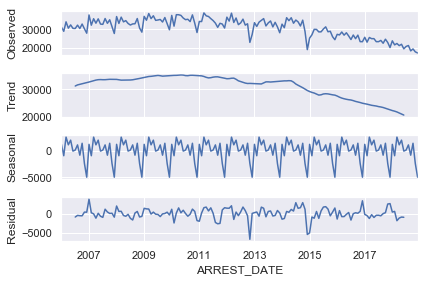

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.set_index('ARREST_DATE').resample('M')['count'].count(), 
                            model='additive') #ref) https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
result.plot()
plt.show()

In [10]:
# https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz
df_precinct = gpd.read_file('Police Precincts/geo_export_bf3a580e-5e32-463e-a39e-5c7a9c0405cf.shp')
print(df_precinct.shape)
df_precinct.head(3)

(77, 4)


,precinct,shape_area,shape_leng,geometry
0,1.0,4.731472e+07,80797.248793,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,5.0,1.808880e+07,18676.124259,"POLYGON ((-73.98864 40.72293, -73.98869 40.722..."
2,6.0,2.209819e+07,26402.900669,"POLYGON ((-73.99968 40.73855, -73.99684 40.737..."


C:\Users\bomsoo\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


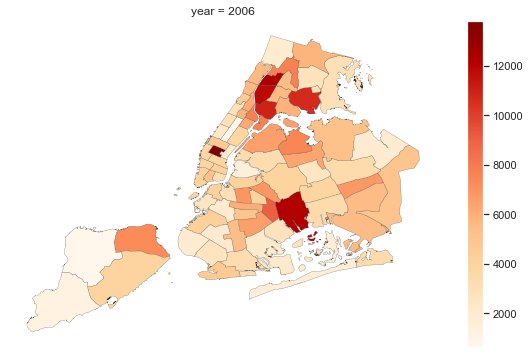

C:\Users\bomsoo\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


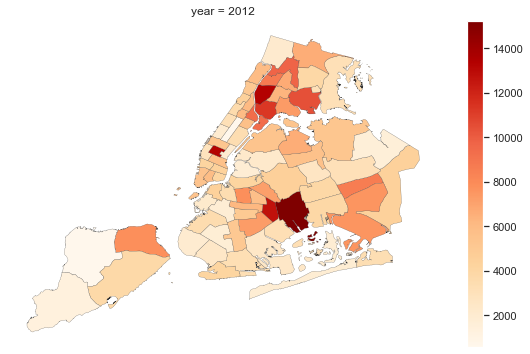

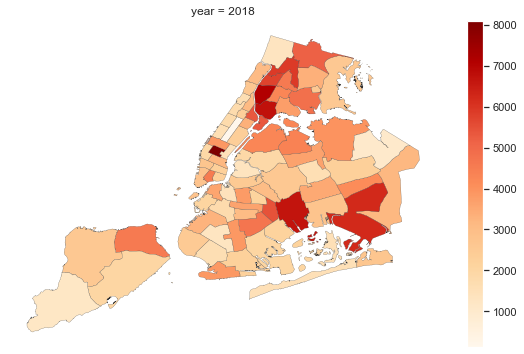

In [11]:
for year in [2006,2012,2018]:
    fig, ax = plt.subplots(1, figsize=(10, 6))
    df_precinct.join(
        df.loc[df['year']==year].groupby('ARREST_PRECINCT')['count'].count(),
        on='precinct', how='left'
    ).plot(ax=ax, column='count', cmap='OrRd', linewidth=0.2, edgecolor='0.2', legend=True, figsize=(10,6))
    ax.axis('off')
    plt.title('year = %s'%year)
    plt.show()

In [12]:
# data source) https://www1.nyc.gov/site/planning/planning-level/nyc-population/current-future-populations.page
nyc_pop = pd.DataFrame({'year':       [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], 
                        'population': [8.190,8.273,8.348,8.399,8.437,8.468,8.476,8.438,8.399]})
nyc_pop['population'] = nyc_pop['population'] * 1000000

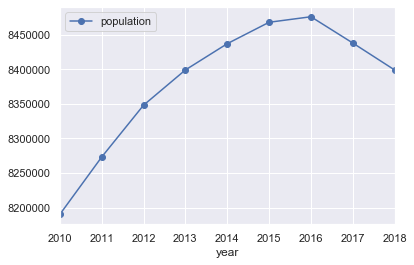

In [13]:
nyc_pop.plot(x='year', y='population', marker='o')

In [14]:
arrest_count = df.groupby('year')['count'].sum()
arrest_count

year
2006    371934
2007    403231
2008    401529
2009    421316
2010    422322
2011    412859
2012    396280
2013    393809
2014    387727
2015    339470
2016    314864
2017    286225
2018    246773
Name: count, dtype: int64

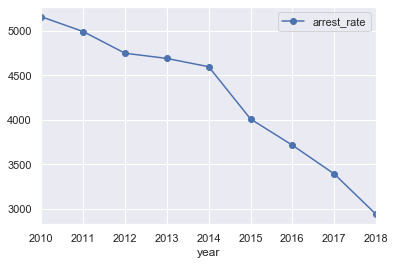

,year,population,count,arrest_rate
0,2010,8190000.0,422322,5156.556777
1,2011,8273000.0,412859,4990.438777
2,2012,8348000.0,396280,4747.005271
3,2013,8399000.0,393809,4688.760567
4,2014,8437000.0,387727,4595.555292
5,2015,8468000.0,339470,4008.856873
6,2016,8476000.0,314864,3714.771118
7,2017,8438000.0,286225,3392.095283
8,2018,8399000.0,246773,2938.123586


In [15]:
nyc_arrests = nyc_pop.join(arrest_count, on='year', how='left')
nyc_arrests['arrest_rate'] = nyc_arrests['count'] / nyc_arrests['population'] * 100000 # https://oag.ca.gov/sites/all/files/agweb/pdfs/cjsc/stats/computational_formulas.pdf
nyc_arrests.plot(x='year', y='arrest_rate', marker='o'); plt.show()
nyc_arrests

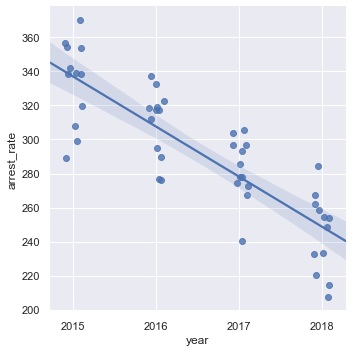

In [16]:
df_month = df.groupby(['year','month']).count().reset_index(drop=False)
df_month = df_month.join(nyc_pop.set_index('year'), on='year', how='left')
df_month['arrest_rate'] = df_month['count'] / df_month['population'] * 100000
df_month_2015_2018 = df_month.loc[df_month['year']>=2015]

sns.lmplot(x='year', y='arrest_rate', data=df_month_2015_2018, ci=95, x_jitter=0.1) # https://seaborn.pydata.org/tutorial/regression.html
plt.xticks([2015,2016,2017,2018])
plt.show()

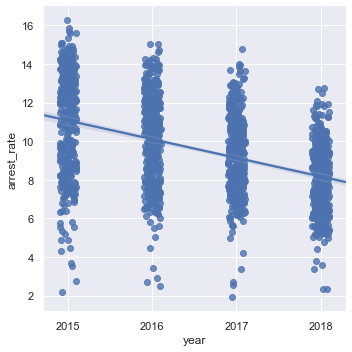

In [17]:
df_day = df.groupby(['year','month','day']).count().reset_index(drop=False)
df_day = df_day.join(nyc_pop.set_index('year'), on='year', how='left')
df_day['arrest_rate'] = df_day['count'] / df_day['population'] * 100000
df_day_2015_2018 = df_day.loc[df_day['year']>=2015]

sns.lmplot(x='year', y='arrest_rate', data=df_day_2015_2018, ci=95, x_jitter=0.1) # https://seaborn.pydata.org/tutorial/regression.html
plt.xticks([2015,2016,2017,2018])
plt.show()

In [18]:
PD_DESC_freq = df.loc[df['year']==2018,'PD_DESC'].value_counts()
PD_DESC_freq.reset_index().rename(columns={'index':'PD_DESC','PD_DESC':'arrest_count_2018'}).head(11)

,PD_DESC,arrest_count_2018
0,ASSAULT 3,26611
1,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",23405
2,"TRAFFIC,UNCLASSIFIED MISDEMEAN",14856
3,"ASSAULT 2,1,UNCLASSIFIED",11763
4,"CONTROLLED SUBSTANCE, POSSESSION 7",9982
5,"ROBBERY,UNCLASSIFIED,OPEN AREAS",8972
6,"LARCENY,GRAND FROM OPEN AREAS,UNCLASSIFIED",8386
7,"MARIJUANA, POSSESSION 4 & 5",8147
8,"PUBLIC ADMINISTRATION,UNCLASSIFIED FELONY",7590
9,"THEFT OF SERVICES, UNCLASSIFIED",7288


In [19]:
PD_DESC_freq_top5 = PD_DESC_freq.index[0:5]
PD_DESC_freq_top5

Index(['ASSAULT 3', 'LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED',
       'TRAFFIC,UNCLASSIFIED MISDEMEAN', 'ASSAULT 2,1,UNCLASSIFIED',
       'CONTROLLED SUBSTANCE, POSSESSION 7'],
      dtype='object')

In [20]:
df.loc[df['PD_DESC'].apply(lambda x: x in PD_DESC_freq_top5),['PD_DESC','LAW_CAT_CD']]\
  .drop_duplicates().sort_values('PD_DESC').reset_index(drop=True)

,PD_DESC,LAW_CAT_CD
0,"ASSAULT 2,1,UNCLASSIFIED",F
1,"ASSAULT 2,1,UNCLASSIFIED",M
2,ASSAULT 3,M
3,"CONTROLLED SUBSTANCE, POSSESSION 7",M
4,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",M
5,"TRAFFIC,UNCLASSIFIED MISDEMEAN",M


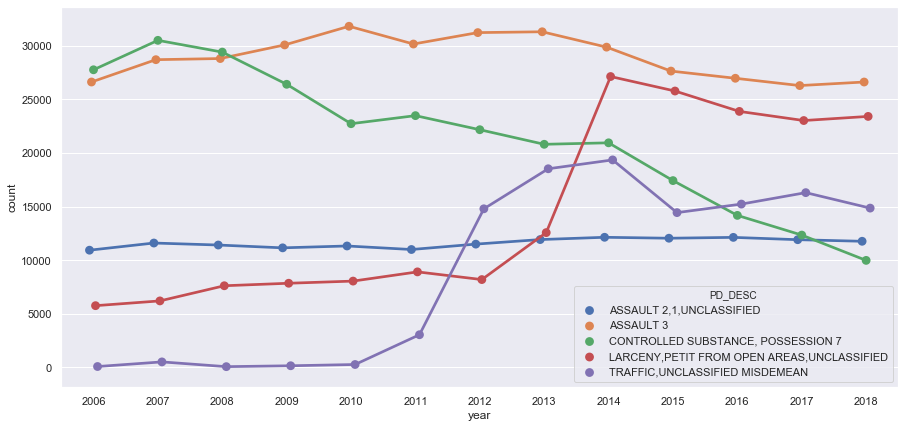

In [21]:
data = df.loc[df['PD_DESC'].apply(lambda x: x in PD_DESC_freq_top5)].\
          groupby(['year','PD_DESC'])['count'].count().\
          reset_index()

fig, ax = plt.subplots(figsize=(15,7))
sns.pointplot(ax=ax, x='year', y='count', hue='PD_DESC', data=data, capsize=.2, dodge=True)
plt.show()

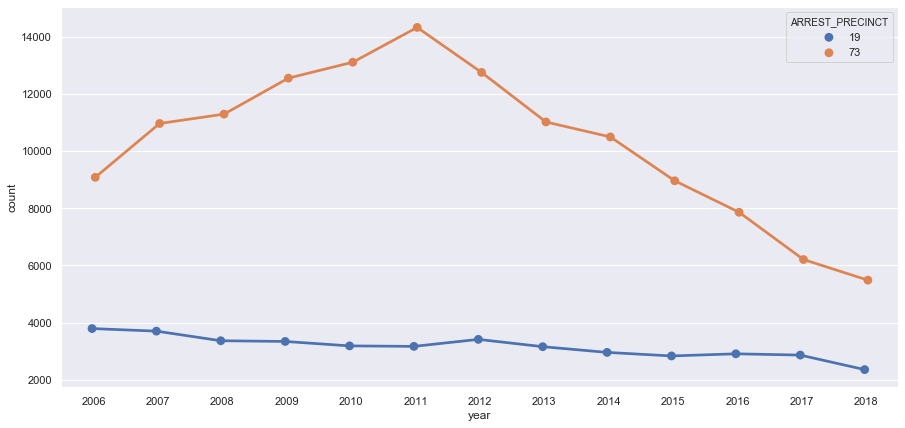

In [22]:
data = df.loc[df['ARREST_PRECINCT'].apply(lambda x: x in [19,73])].\
          groupby(['year','ARREST_PRECINCT'])['count'].count().\
          reset_index()

fig, ax = plt.subplots(figsize=(15,7))
sns.pointplot(ax=ax, x='year', y='count', hue='ARREST_PRECINCT', data=data, capsize=.2, dodge=True)
plt.show()

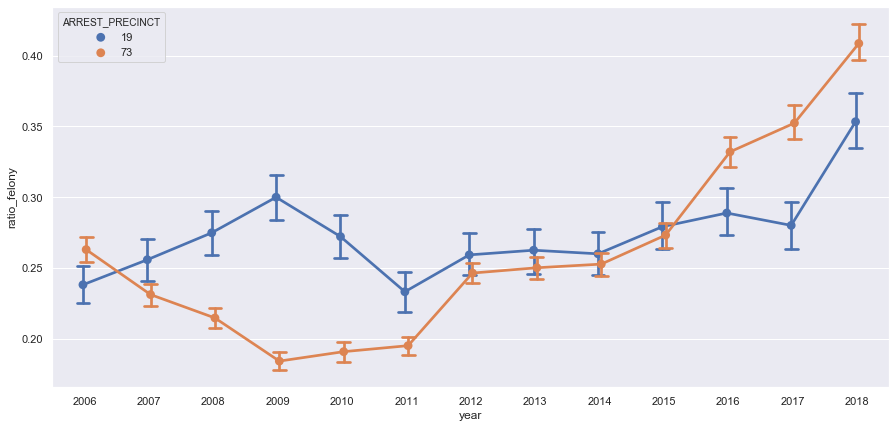

In [23]:
df['ratio_felony'] = df['LAW_CAT_CD'].apply(lambda x: x=='F' if pd.notnull(x) else False)
data2 = df.loc[df['ARREST_PRECINCT'].apply(lambda x: x in [19,73])]

fig, ax = plt.subplots(figsize=(15,7))
sns.pointplot(ax=ax, x='year', y='ratio_felony', hue='ARREST_PRECINCT', data=data2, ci=95, capsize=.2, dodge=True)
plt.show()